### Task:
You will implement 3 separate autoencoders using the MNIST data.
1. Linear AutoEncoder
2. Non-Linear AutoEncoder
3. Advanced Stacked AutoEncoder

### Dataset:
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

# Imports

In [ ]:
import torch
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch. nn as nn

import matplotlib.pyplot as plt
import random
import numpy as np

# Random Seed for Reproducibility

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Hyperparams

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Dataset

In [ ]:
## Load dataset

transformations = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor() # automaticly normalizes data in range of [0, 1]
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transformations,
    download=True
)

## Define data loaders

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 222583537.64it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24125810.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 104770358.99it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16755082.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_data_tovisualize = next(iter(train_loader))
test_data_tovisualize = next(iter(test_loader))

# Helpers

## Training loop

In [ ]:
def train(train_dataloader, test_dataloader, model, criterion, optimizer):
    print("TRAINING STARTED ---")

    train_losses = []
    test_losses = []
    for epoch in range(NUM_EPOCHS):
        model.train()
        for data in train_dataloader:
            image, _ = data
            image = image.cuda()
            optimizer.zero_grad()
            pred = model(image)
            loss = criterion(pred, image)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in test_dataloader:
                image, _ = data
                image = image.cuda()
                pred = model(image)
                test_loss += criterion(pred, image).item()
        epoch_test_loss = test_loss/len(test_dataloader)
        print(f"EPOCH {epoch+1} \t--> train loss: {loss.item()} \t test loss: {epoch_test_loss}")

        test_losses.append(epoch_test_loss)

    print("END OF THE TRAINING ---")

    return model, train_losses, test_losses

## Visualization

In [ ]:
def eval_and_visualize(data, model, model_type, k, dataset):
    model.eval()
    img, lbl = data
    images = [img[lbl == i][0] for i in range(10)] # get 1 sample per digit
    preds = [model(i.cuda()).cpu().detach().numpy() for i in images]

    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(18, 2))
    axes[0][0].set_ylabel('Input', fontsize=14)
    axes[1][0].set_ylabel('Output', fontsize=14)

    for i in range(10):
        axes[0][i].imshow(images[i].reshape(28, 28), cmap="gray")
        axes[1][i].imshow(preds[i][0][0], cmap="gray")

    fig.suptitle(f"Input-Output Images for {model_type} with k:{k} -- {dataset}")


# Linear AutoEncoder

## Define the network

In [ ]:
class LinearAutoEncoder(nn.Module):
    def __init__(self, k):
        super(LinearAutoEncoder, self).__init__()

        self.encoder = nn.Linear(784, k) #  map the input into k features

        self.decoder = nn.Linear(k, 784) # reconstruct the input

    def forward(self, x):
        x = x.view(-1, 784) # flatten the input - batch_size X 784 dimensions
        x = self.encoder(x) # encoded
        x = self.decoder(x) # decoded
        output = x.view(-1, 1, 28, 28) # reshape back to 28x28 - batch_size X channels X height X width
        return output

## Train

In [ ]:
trained_models_linear = []

for k in [10, 50, 100]:
    print(f"k = {k}\n")
    model = LinearAutoEncoder(k)
    model = model.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    print(model)
    print("\n")
    model, train_loss, test_loss = train(train_loader, test_loader, model, criterion, optimizer)
    print("\n")
    print("*"*70)
    print("\n")

    trained_models_linear.append({
        "model": model,
        "k": k,
        "train_loss": train_loss,
        "test_loss": test_loss
    })


k = 10

LinearAutoEncoder(
  (encoder): Linear(in_features=784, out_features=10, bias=True)
  (decoder): Linear(in_features=10, out_features=784, bias=True)
)


TRAINING STARTED ---
EPOCH 1 	--> train loss: 0.04622960090637207 	 test loss: 0.0475775961634479
EPOCH 2 	--> train loss: 0.040021929889917374 	 test loss: 0.03913401680279382
EPOCH 3 	--> train loss: 0.036819469183683395 	 test loss: 0.036361338146313836
EPOCH 4 	--> train loss: 0.03684167563915253 	 test loss: 0.034818725188887574
EPOCH 5 	--> train loss: 0.03413979709148407 	 test loss: 0.034304194010888474
EPOCH 6 	--> train loss: 0.032728053629398346 	 test loss: 0.0341621303011345
EPOCH 7 	--> train loss: 0.0354214683175087 	 test loss: 0.03409646399602105
EPOCH 8 	--> train loss: 0.034741874784231186 	 test loss: 0.03407029053078422
EPOCH 9 	--> train loss: 0.03536625951528549 	 test loss: 0.03406634608495839
EPOCH 10 	--> train loss: 0.03349429368972778 	 test loss: 0.034045131877064705
END OF THE TRAINING ---


******

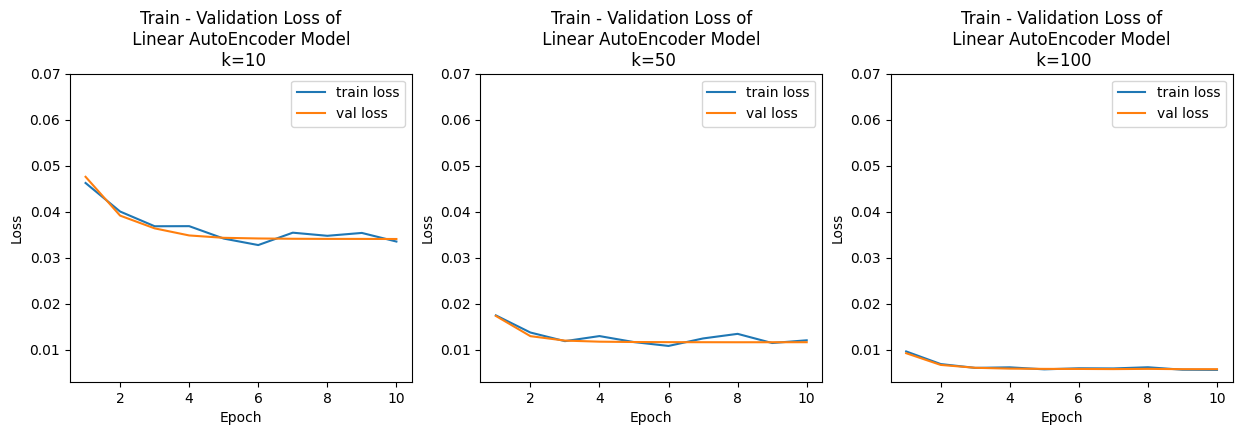

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_linear[0]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_linear[0]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Linear AutoEncoder Model \n k=" + str(trained_models_linear[0]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_linear[1]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_linear[1]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Linear AutoEncoder Model \n k=" + str(trained_models_linear[1]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_linear[2]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_linear[2]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Linear AutoEncoder Model \n k=" + str(trained_models_linear[2]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Visualization

### Test dataset

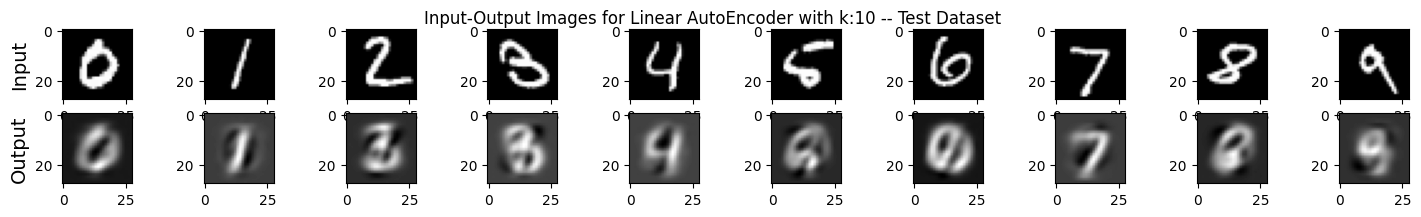

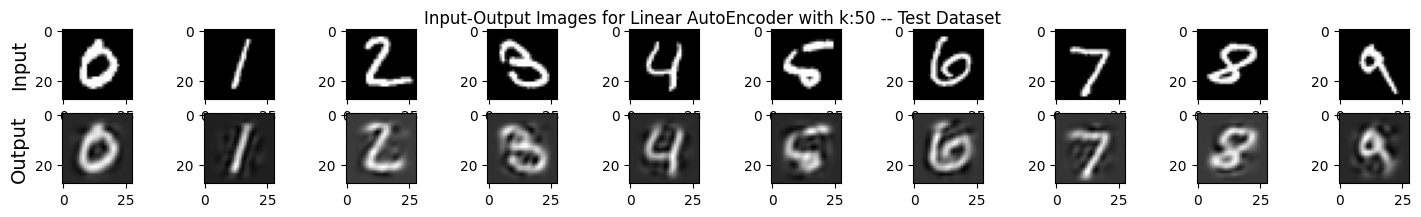

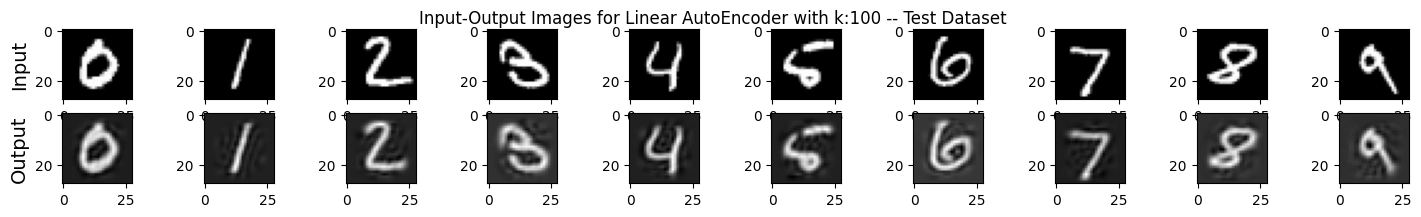

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_linear]:
    eval_and_visualize(test_data_tovisualize, model, "Linear AutoEncoder", k, "Test Dataset")

### Train dataset

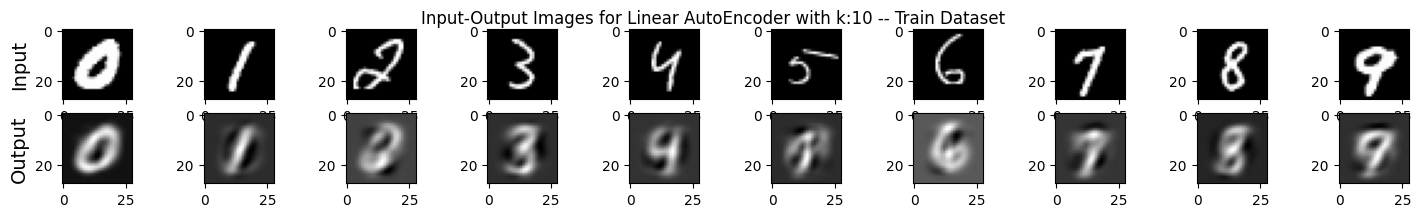

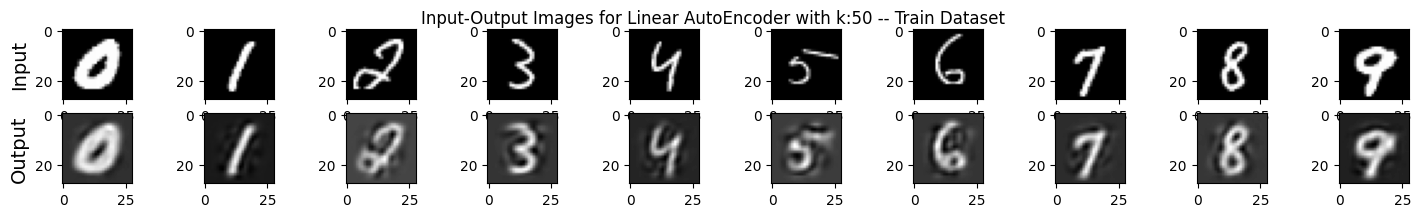

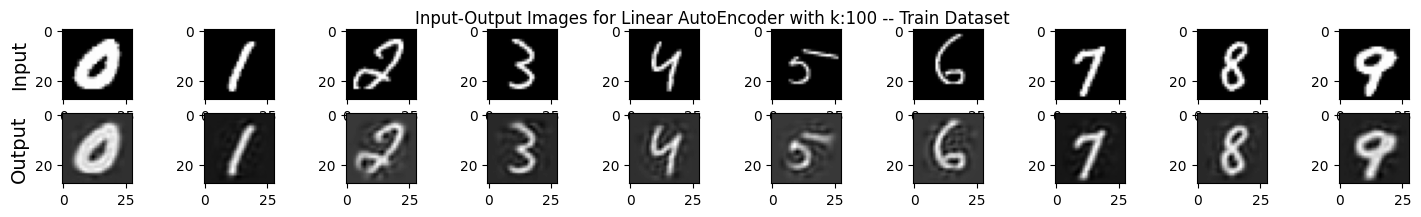

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_linear]:
    eval_and_visualize(train_data_tovisualize, model, "Linear AutoEncoder", k, "Train Dataset")

# Non-Linear AutoEncoder

## Define the network

In [ ]:
class NonLinearAutoEncoder(nn.Module):
    def __init__(self, k):
        super(NonLinearAutoEncoder, self).__init__()

        self.encoder = nn.Linear(784, k) #  map the input into k features
        self.relu = nn.ReLU()

        self.decoder = nn.Linear(k, 784) # reconstruct the input
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 784) # flatten the input - batch_size X 784 dimensions
        x = self.encoder(x) # encoded
        x = self.relu(x)
        x = self.decoder(x) # decoded
        x = self.sigmoid(x)
        output = x.view(-1, 1, 28, 28) # reshaped - batch_size X channels X height X width
        return output

## Train

In [ ]:
trained_models_nonlinear = []

for k in [10, 50, 100]:
    print(f"k = {k}\n")

    model = NonLinearAutoEncoder(k)
    model = model.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    print(model)

    print("\n")
    model, train_loss, test_loss = train(train_loader, test_loader, model, criterion, optimizer)
    print("\n")
    print("*"*70)
    print("\n")

    trained_models_nonlinear.append({
        "model": model,
        "k": k,
        "train_loss": train_loss,
        "test_loss": test_loss
    })

k = 10

NonLinearAutoEncoder(
  (encoder): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
  (decoder): Linear(in_features=10, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


TRAINING STARTED ---
EPOCH 1 	--> train loss: 0.056536588817834854 	 test loss: 0.0582468907195556
EPOCH 2 	--> train loss: 0.049411218613386154 	 test loss: 0.04868872284511976
EPOCH 3 	--> train loss: 0.04718635603785515 	 test loss: 0.04502557779226122
EPOCH 4 	--> train loss: 0.041362203657627106 	 test loss: 0.04298438150671464
EPOCH 5 	--> train loss: 0.042492229491472244 	 test loss: 0.04174724211798438
EPOCH 6 	--> train loss: 0.041831936687231064 	 test loss: 0.04094804804536361
EPOCH 7 	--> train loss: 0.04299624636769295 	 test loss: 0.040392381999688816
EPOCH 8 	--> train loss: 0.0389777310192585 	 test loss: 0.04001668048433111
EPOCH 9 	--> train loss: 0.03785516694188118 	 test loss: 0.03736476743994634
EPOCH 10 	--> train loss: 0.03733322024345398 	 test loss: 0.03695867

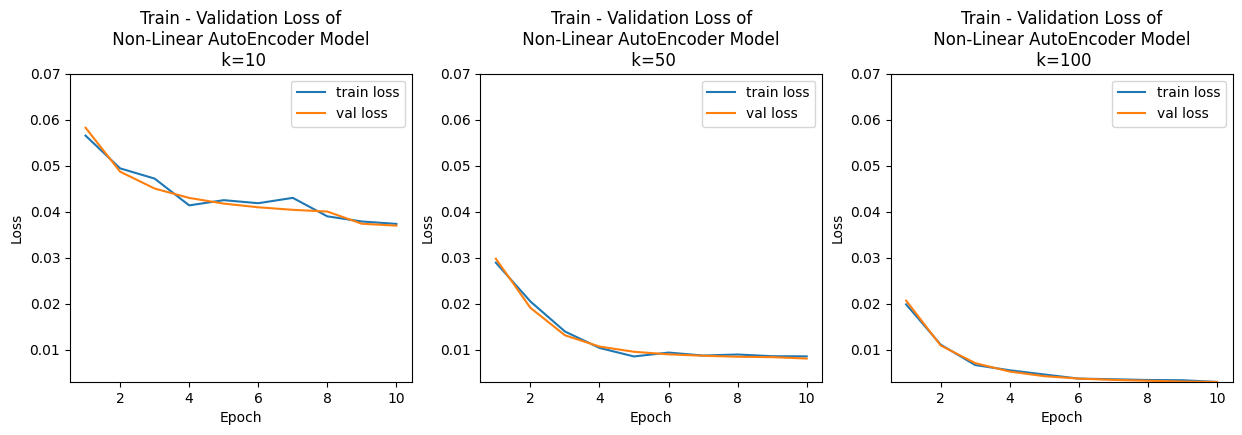

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_nonlinear[0]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_nonlinear[0]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Non-Linear AutoEncoder Model \n k=" + str(trained_models_nonlinear[0]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_nonlinear[1]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_nonlinear[1]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Non-Linear AutoEncoder Model \n k=" + str(trained_models_nonlinear[1]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_nonlinear[2]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_nonlinear[2]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Non-Linear AutoEncoder Model \n k=" + str(trained_models_nonlinear[2]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Visualization

### Test dataset

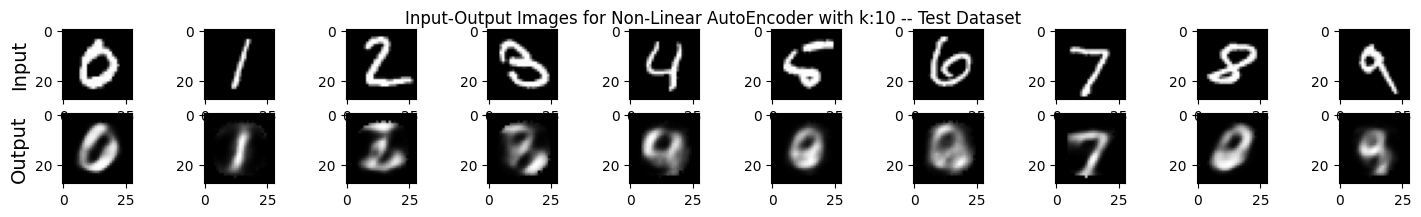

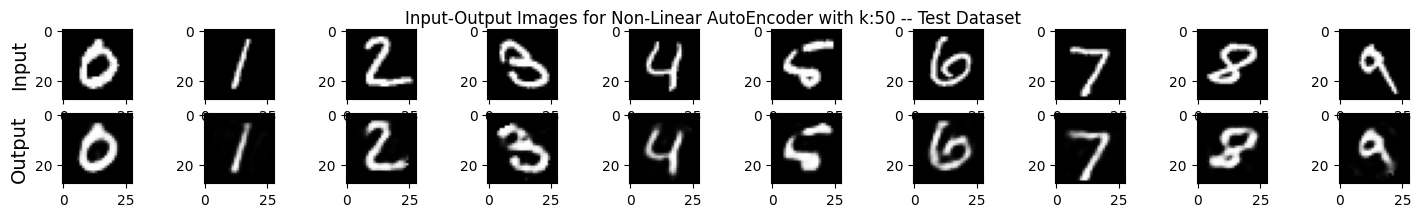

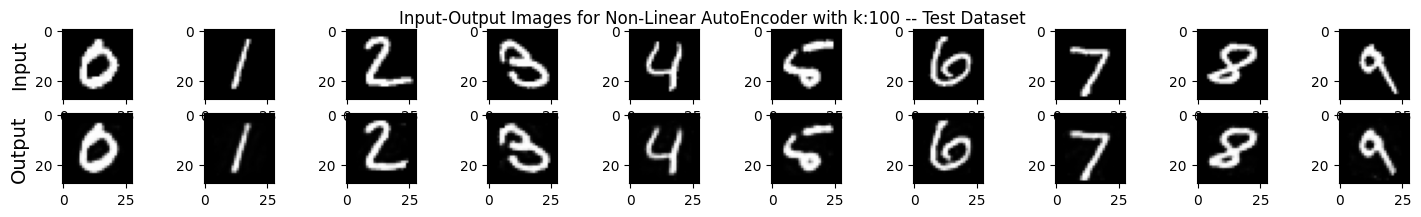

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_nonlinear]:
    eval_and_visualize(test_data_tovisualize, model, "Non-Linear AutoEncoder", k, "Test Dataset")

### Train dataset

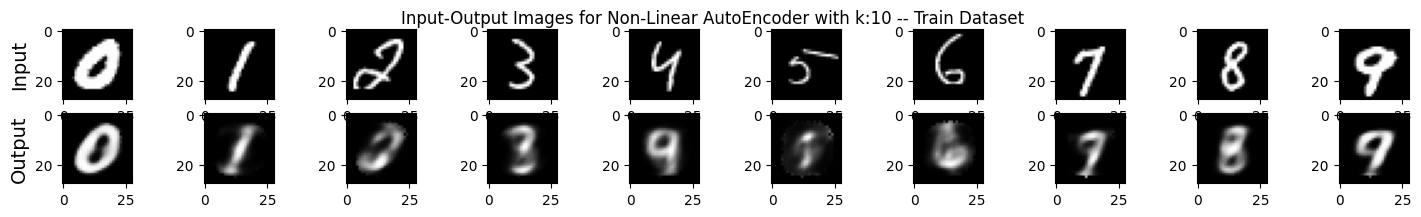

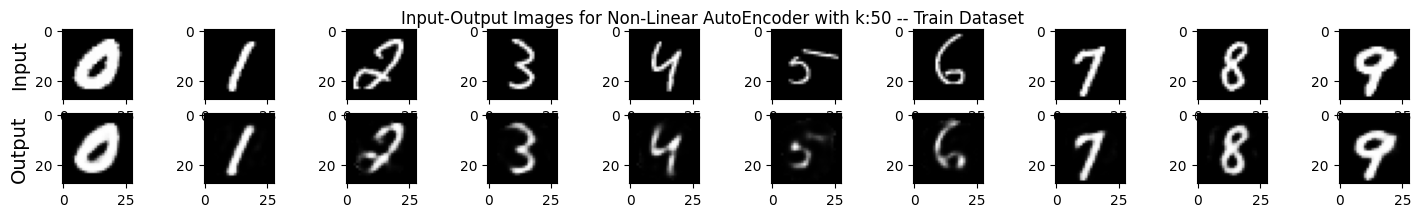

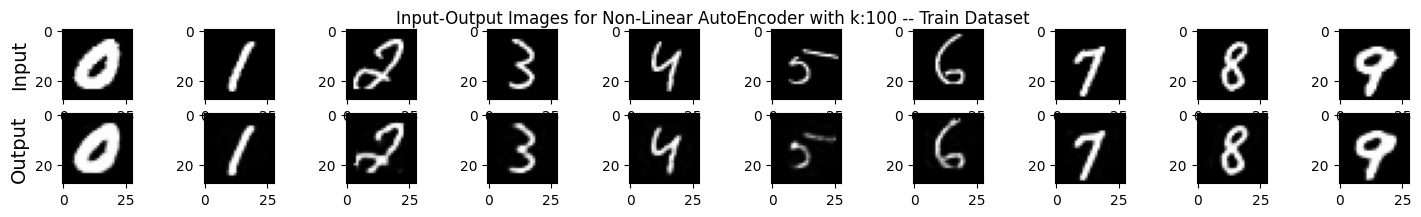

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_nonlinear]:
    eval_and_visualize(train_data_tovisualize, model, "Non-Linear AutoEncoder", k, "Train Dataset")

# Stacked AutoEncoder - Linear

## Define the network

In [ ]:
class StackedAutoEncoder_2(nn.Module):
    def __init__(self, k):
        super(StackedAutoEncoder_2, self).__init__()

        # encoder layers:
        self.encoder_1 = nn.Linear(784, 2*k)
        self.encoder_2 = nn.Linear(2*k, k)

        # decoder layers:
        self.decoder_1 = nn.Linear(k, 2*k)
        self.decoder_2 = nn.Linear(2*k, 784)

    def forward(self, x):
        x = x.view(-1, 784) # flatten the input - batch_size X 784 dimensions
        x = self.encoder_2(self.encoder_1(x)) # encoded
        x = self.decoder_2(self.decoder_1(x)) # decoded
        output = x.view(-1, 1, 28, 28) # reshaped - batch_size X channels X height X width
        return output

## Train

In [ ]:
trained_models_stacked2 = []

for k in [10, 50, 100]:
    print(f"k = {k}\n")
    model = StackedAutoEncoder_2(k)
    model = model.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    print(model)
    print("\n")
    model, train_loss, test_loss = train(train_loader, test_loader, model, criterion, optimizer)
    print("\n")
    print("*"*70)
    print("\n")

    trained_models_stacked2.append({
        "model": model,
        "k": k,
        "train_loss": train_loss,
        "test_loss": test_loss
    })

k = 10

StackedAutoEncoder_2(
  (encoder_1): Linear(in_features=784, out_features=20, bias=True)
  (encoder_2): Linear(in_features=20, out_features=10, bias=True)
  (decoder_1): Linear(in_features=10, out_features=20, bias=True)
  (decoder_2): Linear(in_features=20, out_features=784, bias=True)
)


TRAINING STARTED ---
EPOCH 1 	--> train loss: 0.0424451008439064 	 test loss: 0.04065446333983277
EPOCH 2 	--> train loss: 0.03513682633638382 	 test loss: 0.034789332577699346
EPOCH 3 	--> train loss: 0.03598598390817642 	 test loss: 0.03421722095506855
EPOCH 4 	--> train loss: 0.03372786194086075 	 test loss: 0.03409339867155008
EPOCH 5 	--> train loss: 0.03520321846008301 	 test loss: 0.034089583125484144
EPOCH 6 	--> train loss: 0.03577739745378494 	 test loss: 0.034087978869299346
EPOCH 7 	--> train loss: 0.032132867723703384 	 test loss: 0.03409575133384028
EPOCH 8 	--> train loss: 0.03378024697303772 	 test loss: 0.03407546106867398
EPOCH 9 	--> train loss: 0.035624194890260696 	 test

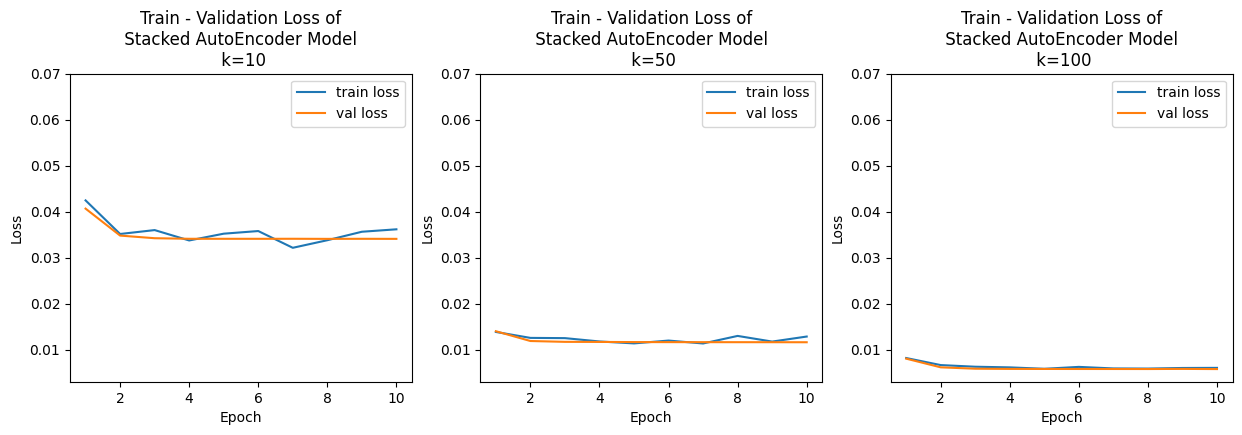

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked2[0]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked2[0]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Stacked AutoEncoder Model \n k=" + str(trained_models_stacked2[0]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked2[1]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked2[1]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Stacked AutoEncoder Model \n k=" + str(trained_models_stacked2[1]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked2[2]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked2[2]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Stacked AutoEncoder Model \n k=" + str(trained_models_stacked2[2]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Visualization

### Test dataset

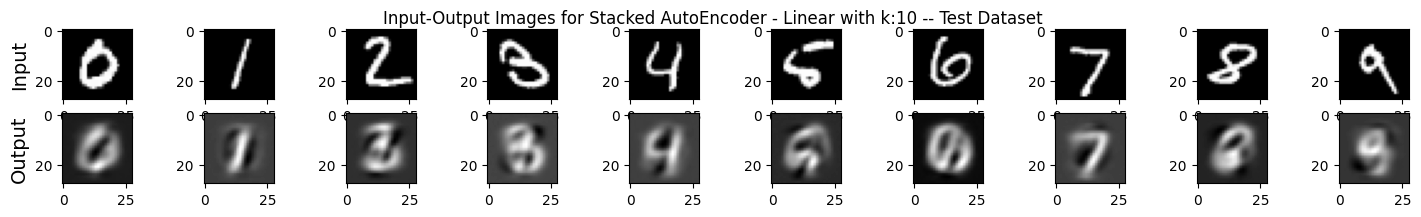

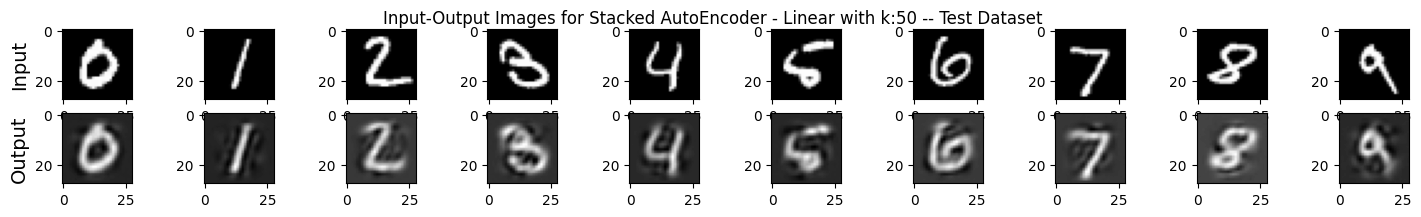

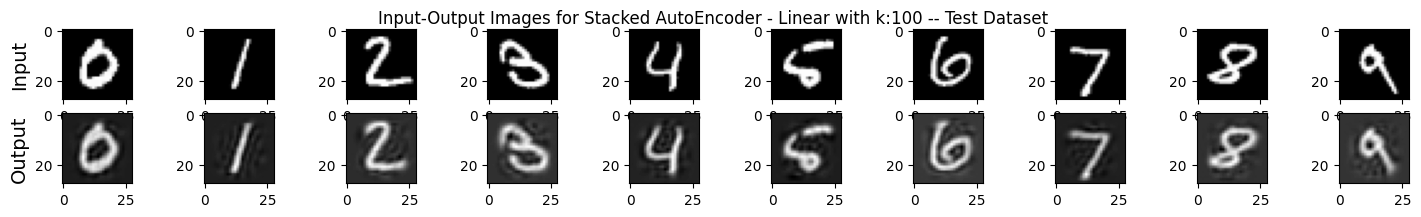

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_stacked2]:
    eval_and_visualize(test_data_tovisualize, model, "Stacked AutoEncoder - Linear", k, "Test Dataset")

### Train dataset

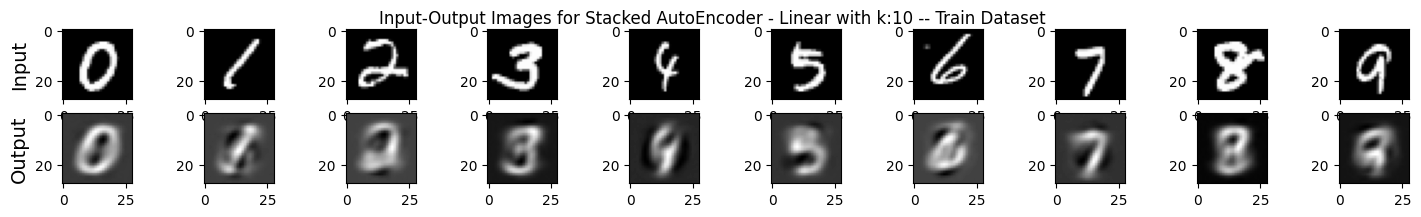

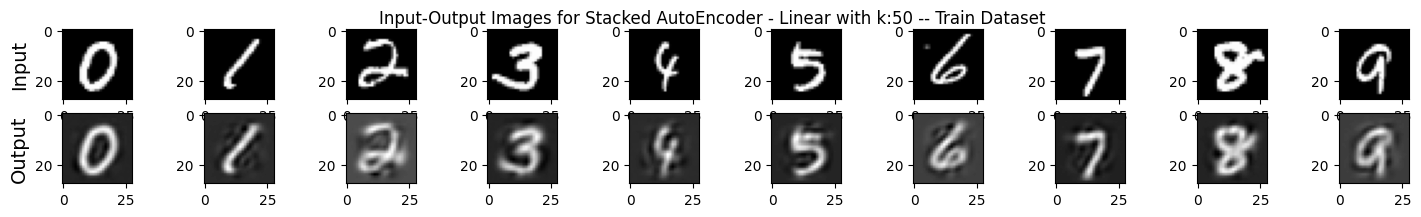

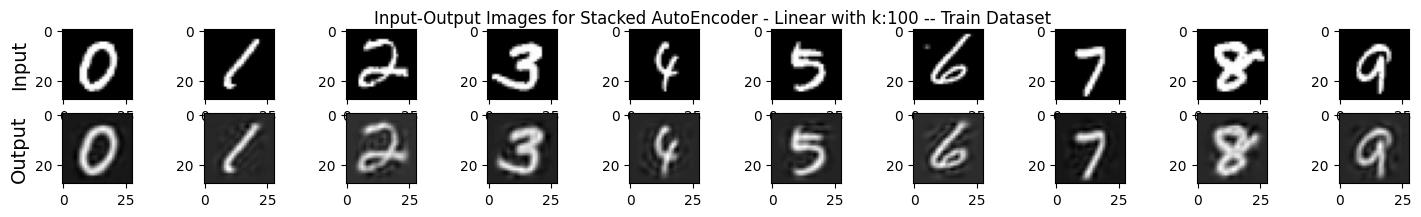

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_stacked2]:
    eval_and_visualize(train_data_tovisualize, model, "Stacked AutoEncoder - Linear", k, "Train Dataset")

# Stacked AutoEncoder - Non-Linear

## Define the network

In [ ]:
class StackedAutoEncoder(nn.Module):
    def __init__(self, k):
        super(StackedAutoEncoder, self).__init__()

        # encoder layers:
        self.encoder_1 = nn.Linear(784, 2*k)
        self.encoder_2 = nn.Linear(2*k, k)
        self.relu = nn.ReLU()

        # decoder layers:
        self.decoder_1 = nn.Linear(k, 2*k)
        self.decoder_2 = nn.Linear(2*k, 784)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 784) # flatten the input - batch_size X 784 dimensions
        x = self.encoder_2(self.encoder_1(x)) # encoded
        x = self.relu(x)
        x = self.decoder_2(self.decoder_1(x)) # decoded
        x = self.sigmoid(x)
        output = x.view(-1, 1, 28, 28) # reshaped - batch_size X channels X height X width
        return output

## Train

In [ ]:
trained_models_stacked = []

for k in [10, 50, 100]:
    print(f"k = {k}\n")
    model = StackedAutoEncoder(k)
    model = model.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    print(model)
    print("\n")
    model, train_loss, test_loss = train(train_loader, test_loader, model, criterion, optimizer)
    print("\n")
    print("*"*70)
    print("\n")

    trained_models_stacked.append({
        "model": model,
        "k": k,
        "train_loss": train_loss,
        "test_loss": test_loss
    })

k = 10

StackedAutoEncoder(
  (encoder_1): Linear(in_features=784, out_features=20, bias=True)
  (encoder_2): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (decoder_1): Linear(in_features=10, out_features=20, bias=True)
  (decoder_2): Linear(in_features=20, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


TRAINING STARTED ---
EPOCH 1 	--> train loss: 0.04785339534282684 	 test loss: 0.047400707826961444
EPOCH 2 	--> train loss: 0.04140384495258331 	 test loss: 0.03947077474639386
EPOCH 3 	--> train loss: 0.03478744253516197 	 test loss: 0.03623616502066202
EPOCH 4 	--> train loss: 0.03512882813811302 	 test loss: 0.03546382022337823
EPOCH 5 	--> train loss: 0.03322847932577133 	 test loss: 0.03416753449489044
EPOCH 6 	--> train loss: 0.03193764388561249 	 test loss: 0.03297514869253847
EPOCH 7 	--> train loss: 0.03340240195393562 	 test loss: 0.03263666551513008
EPOCH 8 	--> train loss: 0.03428265079855919 	 test loss: 0.03212521364322946
EPOCH 9 	--> tra

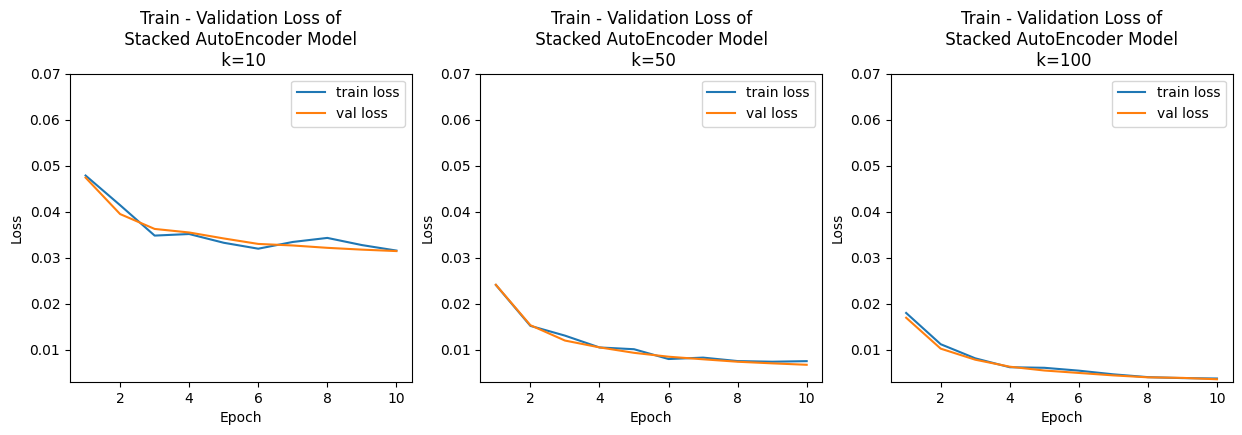

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked[0]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked[0]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Stacked AutoEncoder Model \n k=" + str(trained_models_stacked[0]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked[1]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked[1]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Stacked AutoEncoder Model \n k=" + str(trained_models_stacked[1]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.ylim(0.003, 0.07)
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked[2]["train_loss"]], label="train loss")
plt.plot(range(1,NUM_EPOCHS+1), [loss for loss in trained_models_stacked[2]["test_loss"]], label="val loss")
plt.legend()
plt.title(f"Train - Validation Loss of\n Stacked AutoEncoder Model \n k=" + str(trained_models_stacked[2]["k"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Visualization

### Test dataset

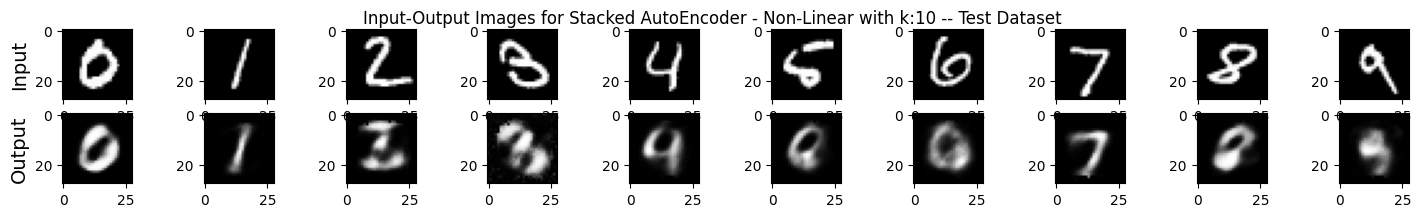

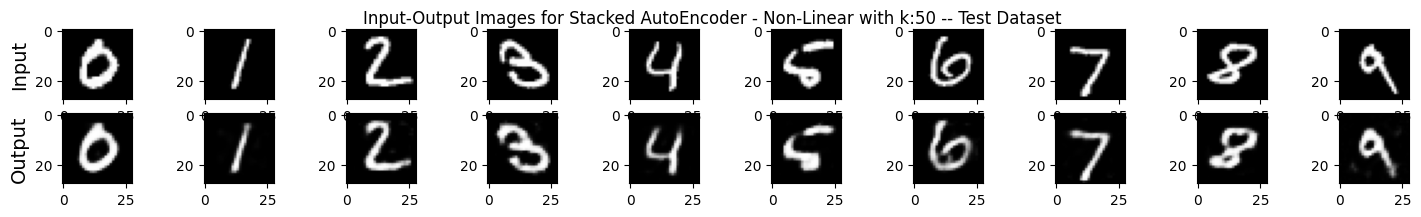

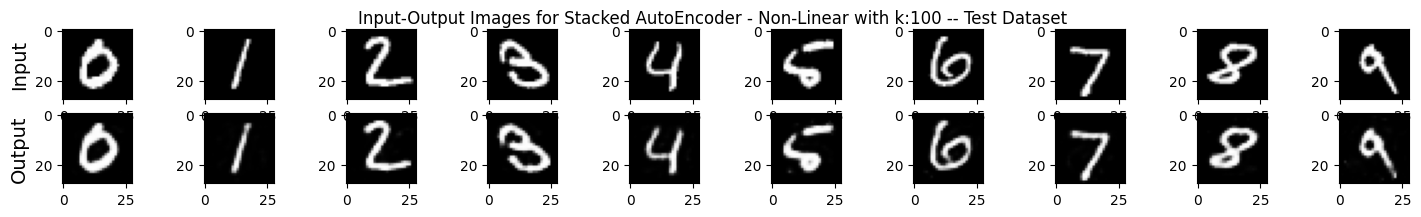

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_stacked]:
    eval_and_visualize(test_data_tovisualize, model, "Stacked AutoEncoder - Non-Linear", k, "Test Dataset")

### Train dataset

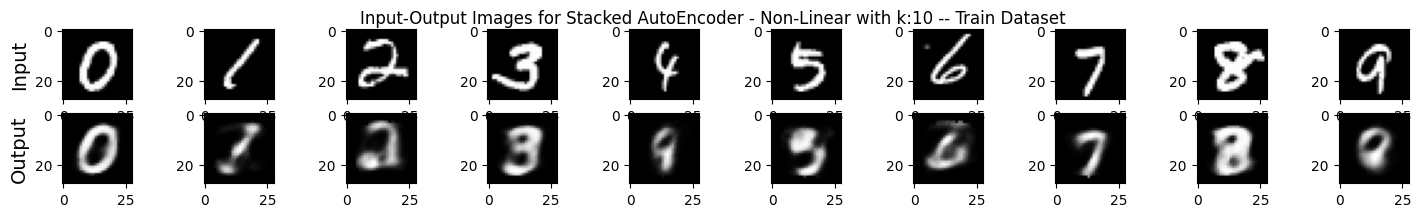

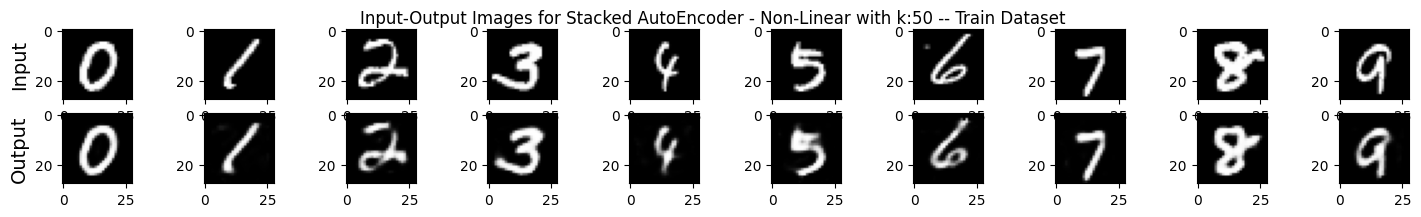

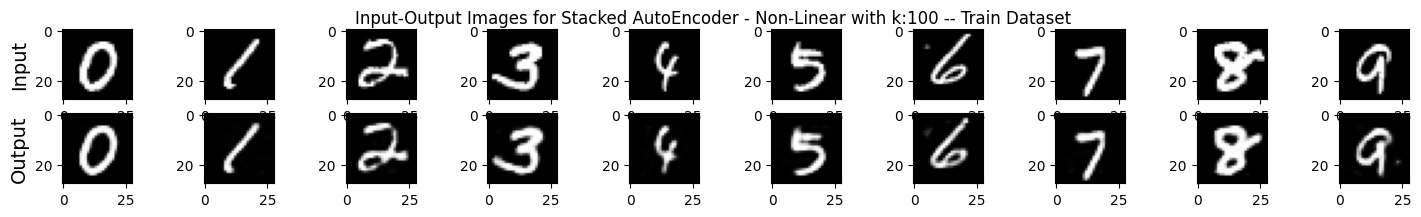

In [ ]:
for model, k in [(m["model"], m["k"]) for m in trained_models_stacked]:
    eval_and_visualize(train_data_tovisualize, model, "Stacked AutoEncoder - Non-Linear", k, "Train Dataset")